In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import copy

def load_pretrained_model(num_classes):
    resnet18_pretrained = models.resnet18(pretrained=True)
    num_ftrs = resnet18_pretrained.fc.in_features
    resnet18_pretrained.fc = nn.Linear(num_ftrs, num_classes)
    return resnet18_pretrained

def prepare_datasets(data_dir, batch_size):
    data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    full_dataset = datasets.ImageFolder(data_dir, transform=data_transform)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    return train_loader, val_loader

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    scaler = GradScaler()

    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_accuracy = 0.0
    best_model = None

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = 100. * correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

            val_loss /= len(val_loader)
            val_losses.append(val_loss)
            val_accuracy = 100. * correct / total
            val_accuracies.append(val_accuracy)

            print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
            print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

            # 保存最佳模型
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_model = copy.deepcopy(model.state_dict())

    return model, train_losses, val_losses, val_accuracies, best_model

def plot_results(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train and Val Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Val Accuracy')

    plt.show()

# 使用示例
data_dir = 'images'
batch_size = 32
num_classes = 200
num_epochs = 10

model = load_pretrained_model(num_classes)
train_loader, val_loader = prepare_datasets(data_dir, batch_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
trained_model, train_losses, val_losses, val_accuracies, best_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)
torch.save(best_model, 'best_model.pth')
plot_results(train_losses, val_losses, val_accuracies)


Epoch 1/10: 100%|██████████| 295/295 [00:17<00:00, 16.41it/s]


Epoch 1, Train Loss: 4.6564, Train Accuracy: 10.88%
Epoch 1, Val Loss: 3.6996, Val Accuracy: 24.43%


Epoch 2/10: 100%|██████████| 295/295 [00:18<00:00, 15.96it/s]


Epoch 2, Train Loss: 3.0751, Train Accuracy: 42.68%
Epoch 2, Val Loss: 2.6301, Val Accuracy: 46.23%


Epoch 3/10: 100%|██████████| 295/295 [00:17<00:00, 16.66it/s]


Epoch 3, Train Loss: 2.1918, Train Accuracy: 61.77%
Epoch 3, Val Loss: 2.0002, Val Accuracy: 58.40%


Epoch 4/10: 100%|██████████| 295/295 [00:16<00:00, 17.44it/s]


Epoch 4, Train Loss: 1.6221, Train Accuracy: 73.92%
Epoch 4, Val Loss: 1.6569, Val Accuracy: 63.70%


Epoch 5/10: 100%|██████████| 295/295 [00:16<00:00, 17.84it/s]


Epoch 5, Train Loss: 1.2309, Train Accuracy: 80.63%
Epoch 5, Val Loss: 1.4074, Val Accuracy: 69.34%


Epoch 6/10: 100%|██████████| 295/295 [00:16<00:00, 17.73it/s]


Epoch 6, Train Loss: 0.9531, Train Accuracy: 85.92%
Epoch 6, Val Loss: 1.2746, Val Accuracy: 70.36%


Epoch 7/10: 100%|██████████| 295/295 [00:16<00:00, 18.06it/s]


In [15]:
# 定义不同的超参数组合
hyperparameters = [
    {'num_epochs': 5, 'lr_fc': 0.001, 'lr_other': 0.001, 'batch_size': 32},
    {'num_epochs': 5, 'lr_fc': 0.001, 'lr_other': 0.002, 'batch_size': 32},
    {'num_epochs': 5, 'lr_fc': 0.001, 'lr_other': 0.003, 'batch_size': 32},
    {'num_epochs': 5, 'lr_fc': 0.001, 'lr_other': 0.001, 'batch_size': 64},
    {'num_epochs': 5, 'lr_fc': 0.001, 'lr_other': 0.002, 'batch_size': 64},
    {'num_epochs': 5, 'lr_fc': 0.001, 'lr_other': 0.003, 'batch_size': 64},
    {'num_epochs': 10, 'lr_fc': 0.001, 'lr_other': 0.001, 'batch_size': 32},
    {'num_epochs': 10, 'lr_fc': 0.001, 'lr_other': 0.002, 'batch_size': 32},
    {'num_epochs': 10, 'lr_fc': 0.001, 'lr_other': 0.003, 'batch_size': 32},
    {'num_epochs': 10, 'lr_fc': 0.001, 'lr_other': 0.001, 'batch_size': 64},
    {'num_epochs': 10, 'lr_fc': 0.001, 'lr_other': 0.002, 'batch_size': 64},
    {'num_epochs': 10, 'lr_fc': 0.001, 'lr_other': 0.003, 'batch_size': 64},
    # 添加更多组合...
]


results = []

for hp in hyperparameters:
    num_epochs = hp['num_epochs']
    lr_fc = hp['lr_fc']
    lr_other = hp['lr_other']
    batch_size = hp['batch_size']
    model = load_pretrained_model(num_classes)
    train_loader, val_loader = prepare_datasets(data_dir, batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD([
        {'params': model.fc.parameters(), 'lr': lr_fc},
        {'params': list(model.parameters())[:-2], 'lr': lr_other}
    ], momentum=0.9)

    trained_model, train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

    results.append({
        'hyperparameters': hp,
        'trained_model': trained_model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    })

# 分析结果并找出最佳组合
best_val_accuracy = 0.0
best_hyperparameters = None
for result in results:
    val_accuracy = result['val_accuracies'][-1]
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_hyperparameters = result['hyperparameters']

print("Best Hyperparameters:", best_hyperparameters)

Epoch 1/5: 100%|██████████| 295/295 [00:16<00:00, 17.82it/s]


Epoch 1, Train Loss: 3.0989, Train Accuracy: 32.68%
Epoch 1, Val Loss: 1.6011, Val Accuracy: 58.02%


Epoch 2/5: 100%|██████████| 295/295 [00:18<00:00, 15.70it/s]


Epoch 2, Train Loss: 1.1239, Train Accuracy: 71.56%
Epoch 2, Val Loss: 1.1576, Val Accuracy: 69.00%


Epoch 3/5: 100%|██████████| 295/295 [00:16<00:00, 17.82it/s]


Epoch 3, Train Loss: 0.6369, Train Accuracy: 84.43%
Epoch 3, Val Loss: 1.0101, Val Accuracy: 71.80%


Epoch 4/5: 100%|██████████| 295/295 [00:16<00:00, 18.02it/s]


Epoch 4, Train Loss: 0.3646, Train Accuracy: 92.44%
Epoch 4, Val Loss: 0.9693, Val Accuracy: 73.49%


Epoch 5/5: 100%|██████████| 295/295 [00:16<00:00, 17.78it/s]


Epoch 5, Train Loss: 0.2086, Train Accuracy: 96.84%
Epoch 5, Val Loss: 0.9175, Val Accuracy: 74.64%


Epoch 1/5: 100%|██████████| 148/148 [00:14<00:00, 10.37it/s]


Epoch 1, Train Loss: 3.8346, Train Accuracy: 22.90%
Epoch 1, Val Loss: 2.3895, Val Accuracy: 45.59%


Epoch 2/5: 100%|██████████| 148/148 [00:14<00:00, 10.31it/s]


Epoch 2, Train Loss: 1.6635, Train Accuracy: 64.04%
Epoch 2, Val Loss: 1.5144, Val Accuracy: 64.46%


Epoch 3/5: 100%|██████████| 148/148 [00:14<00:00, 10.08it/s]


Epoch 3, Train Loss: 1.0295, Train Accuracy: 77.27%
Epoch 3, Val Loss: 1.2933, Val Accuracy: 67.64%


Epoch 4/5: 100%|██████████| 148/148 [00:14<00:00, 10.56it/s]


Epoch 4, Train Loss: 0.7125, Train Accuracy: 85.08%
Epoch 4, Val Loss: 1.1459, Val Accuracy: 70.57%


Epoch 5/5: 100%|██████████| 148/148 [00:13<00:00, 10.58it/s]


Epoch 5, Train Loss: 0.5203, Train Accuracy: 89.78%
Epoch 5, Val Loss: 1.0633, Val Accuracy: 72.86%


Epoch 1/5: 100%|██████████| 74/74 [00:14<00:00,  5.11it/s]


Epoch 1, Train Loss: 4.6204, Train Accuracy: 11.03%
Epoch 1, Val Loss: 3.5350, Val Accuracy: 28.67%


Epoch 2/5: 100%|██████████| 74/74 [00:14<00:00,  5.11it/s]


Epoch 2, Train Loss: 2.7006, Train Accuracy: 48.44%
Epoch 2, Val Loss: 2.2535, Val Accuracy: 52.12%


Epoch 3/5: 100%|██████████| 74/74 [00:14<00:00,  5.05it/s]


Epoch 3, Train Loss: 1.7515, Train Accuracy: 66.91%
Epoch 3, Val Loss: 1.7482, Val Accuracy: 61.58%


Epoch 4/5: 100%|██████████| 74/74 [00:14<00:00,  5.25it/s]


Epoch 4, Train Loss: 1.2914, Train Accuracy: 75.73%
Epoch 4, Val Loss: 1.4750, Val Accuracy: 66.75%


Epoch 5/5: 100%|██████████| 74/74 [00:14<00:00,  5.04it/s]


Epoch 5, Train Loss: 1.0111, Train Accuracy: 80.59%
Epoch 5, Val Loss: 1.3132, Val Accuracy: 68.83%


Epoch 1/5: 100%|██████████| 37/37 [00:15<00:00,  2.39it/s]


Epoch 1, Train Loss: 5.0908, Train Accuracy: 3.99%
Epoch 1, Val Loss: 4.5157, Val Accuracy: 11.96%


Epoch 2/5: 100%|██████████| 37/37 [00:15<00:00,  2.39it/s]


Epoch 2, Train Loss: 3.9240, Train Accuracy: 27.74%
Epoch 2, Val Loss: 3.4093, Val Accuracy: 34.90%


Epoch 3/5: 100%|██████████| 37/37 [00:15<00:00,  2.44it/s]


Epoch 3, Train Loss: 2.9209, Train Accuracy: 49.92%
Epoch 3, Val Loss: 2.6578, Val Accuracy: 46.52%


Epoch 4/5: 100%|██████████| 37/37 [00:14<00:00,  2.47it/s]


Epoch 4, Train Loss: 2.2477, Train Accuracy: 61.93%
Epoch 4, Val Loss: 2.1835, Val Accuracy: 57.04%


Epoch 5/5: 100%|██████████| 37/37 [00:16<00:00,  2.30it/s]


Epoch 5, Train Loss: 1.8134, Train Accuracy: 70.02%
Epoch 5, Val Loss: 1.8981, Val Accuracy: 60.52%


Epoch 1/5: 100%|██████████| 295/295 [00:16<00:00, 17.51it/s]


Epoch 1, Train Loss: 5.0067, Train Accuracy: 5.16%
Epoch 1, Val Loss: 4.5369, Val Accuracy: 12.68%


Epoch 2/5: 100%|██████████| 295/295 [00:16<00:00, 17.85it/s]


Epoch 2, Train Loss: 4.0788, Train Accuracy: 23.26%
Epoch 2, Val Loss: 3.6725, Val Accuracy: 29.90%


Epoch 3/5: 100%|██████████| 295/295 [00:16<00:00, 17.37it/s]


Epoch 3, Train Loss: 3.2818, Train Accuracy: 41.79%
Epoch 3, Val Loss: 2.9857, Val Accuracy: 44.40%


Epoch 4/5: 100%|██████████| 295/295 [00:15<00:00, 18.95it/s]


Epoch 4, Train Loss: 2.6773, Train Accuracy: 54.02%
Epoch 4, Val Loss: 2.4804, Val Accuracy: 53.27%


Epoch 5/5: 100%|██████████| 295/295 [00:15<00:00, 18.68it/s]


Epoch 5, Train Loss: 2.2412, Train Accuracy: 62.42%
Epoch 5, Val Loss: 2.1745, Val Accuracy: 58.52%


Epoch 1/5: 100%|██████████| 148/148 [00:14<00:00, 10.25it/s]


Epoch 1, Train Loss: 5.2319, Train Accuracy: 1.94%
Epoch 1, Val Loss: 4.9708, Val Accuracy: 4.37%


Epoch 2/5: 100%|██████████| 148/148 [00:14<00:00, 10.09it/s]


Epoch 2, Train Loss: 4.7105, Train Accuracy: 10.83%
Epoch 2, Val Loss: 4.5151, Val Accuracy: 15.22%


Epoch 3/5: 100%|██████████| 148/148 [00:14<00:00, 10.30it/s]


Epoch 3, Train Loss: 4.2288, Train Accuracy: 23.68%
Epoch 3, Val Loss: 4.0652, Val Accuracy: 24.72%


Epoch 4/5: 100%|██████████| 148/148 [00:13<00:00, 10.78it/s]


Epoch 4, Train Loss: 3.7585, Train Accuracy: 34.97%
Epoch 4, Val Loss: 3.6536, Val Accuracy: 32.82%


Epoch 5/5: 100%|██████████| 148/148 [00:14<00:00, 10.55it/s]


Epoch 5, Train Loss: 3.3392, Train Accuracy: 44.22%
Epoch 5, Val Loss: 3.2867, Val Accuracy: 38.68%


Epoch 1/5: 100%|██████████| 74/74 [00:14<00:00,  5.04it/s]


Epoch 1, Train Loss: 5.3308, Train Accuracy: 0.81%
Epoch 1, Val Loss: 5.1967, Val Accuracy: 1.61%


Epoch 2/5: 100%|██████████| 74/74 [00:14<00:00,  5.09it/s]


Epoch 2, Train Loss: 5.0339, Train Accuracy: 3.75%
Epoch 2, Val Loss: 4.9589, Val Accuracy: 5.34%


Epoch 3/5: 100%|██████████| 74/74 [00:14<00:00,  4.96it/s]


Epoch 3, Train Loss: 4.7753, Train Accuracy: 9.47%
Epoch 3, Val Loss: 4.7270, Val Accuracy: 10.43%


Epoch 4/5: 100%|██████████| 74/74 [00:14<00:00,  5.27it/s]


Epoch 4, Train Loss: 4.5221, Train Accuracy: 16.14%
Epoch 4, Val Loss: 4.4985, Val Accuracy: 15.22%


Epoch 5/5: 100%|██████████| 74/74 [00:14<00:00,  5.14it/s]


Epoch 5, Train Loss: 4.2738, Train Accuracy: 22.71%
Epoch 5, Val Loss: 4.2765, Val Accuracy: 20.10%


Epoch 1/5: 100%|██████████| 37/37 [00:16<00:00,  2.25it/s]


Epoch 1, Train Loss: 5.4138, Train Accuracy: 0.50%
Epoch 1, Val Loss: 5.3261, Val Accuracy: 0.93%


Epoch 2/5: 100%|██████████| 37/37 [00:15<00:00,  2.46it/s]


Epoch 2, Train Loss: 5.2340, Train Accuracy: 1.27%
Epoch 2, Val Loss: 5.1862, Val Accuracy: 2.33%


Epoch 3/5: 100%|██████████| 37/37 [00:14<00:00,  2.50it/s]


KeyboardInterrupt: 

/opt/conda/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5: 100%|██████████| 295/295 [00:16<00:00, 18.26it/s]


Epoch 1, Train Loss: 3.1213, Train Accuracy: 32.01%
Epoch 1, Val Loss: 1.6263, Val Accuracy: 56.40%


Epoch 2/5: 100%|██████████| 295/295 [00:16<00:00, 17.58it/s]


Epoch 2, Train Loss: 1.1252, Train Accuracy: 71.29%
Epoch 2, Val Loss: 1.1701, Val Accuracy: 67.18%


Epoch 3/5: 100%|██████████| 295/295 [00:16<00:00, 18.29it/s]


Epoch 3, Train Loss: 0.6319, Train Accuracy: 84.34%
Epoch 3, Val Loss: 1.0719, Val Accuracy: 69.85%


Epoch 4/5: 100%|██████████| 295/295 [00:16<00:00, 17.60it/s]


Epoch 4, Train Loss: 0.3588, Train Accuracy: 92.59%
Epoch 4, Val Loss: 0.9936, Val Accuracy: 72.56%


Epoch 5/5: 100%|██████████| 295/295 [00:17<00:00, 16.42it/s]


Epoch 5, Train Loss: 0.2094, Train Accuracy: 96.69%
Epoch 5, Val Loss: 0.9803, Val Accuracy: 73.41%


/opt/conda/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 1/5: 100%|██████████| 295/295 [00:16<00:00, 18.15it/s]


Epoch 1, Train Loss: 5.3644, Train Accuracy: 1.18%
Epoch 1, Val Loss: 5.3233, Val Accuracy: 2.04%


Epoch 2/5: 100%|██████████| 295/295 [00:16<00:00, 18.22it/s]


Epoch 2, Train Loss: 4.8798, Train Accuracy: 2.71%
Epoch 2, Val Loss: 4.7610, Val Accuracy: 2.97%


Epoch 3/5: 100%|██████████| 295/295 [00:15<00:00, 19.15it/s]


Epoch 3, Train Loss: 4.5750, Train Accuracy: 5.24%
Epoch 3, Val Loss: 4.5637, Val Accuracy: 5.43%


Epoch 4/5: 100%|██████████| 295/295 [00:15<00:00, 19.01it/s]


Epoch 4, Train Loss: 4.3398, Train Accuracy: 6.95%
Epoch 4, Val Loss: 4.3788, Val Accuracy: 6.74%


Epoch 5/5: 100%|██████████| 295/295 [00:15<00:00, 19.29it/s]


Epoch 5, Train Loss: 4.1124, Train Accuracy: 9.75%
Epoch 5, Val Loss: 4.2244, Val Accuracy: 9.41%


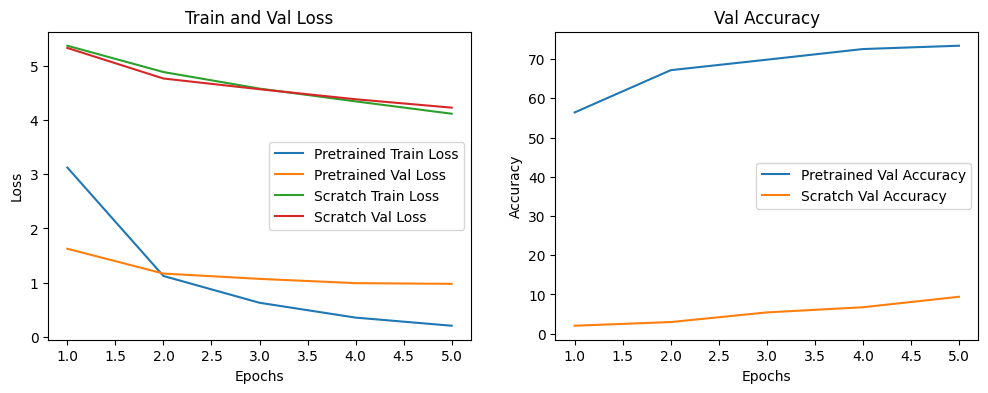

In [11]:
def load_pretrained_model(num_classes, pretrained=True):
    if pretrained:
        model = models.resnet18(pretrained=True)
    else:
        model = models.resnet18(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

def plot_results(train_losses_pre, val_losses_pre, val_accuracies_pre, train_losses_scratch, val_losses_scratch, val_accuracies_scratch):
    epochs_pre = range(1, len(train_losses_pre) + 1)
    epochs_scratch = range(1, len(train_losses_scratch) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_pre, train_losses_pre, label='Pretrained Train Loss')
    plt.plot(epochs_pre, val_losses_pre, label='Pretrained Val Loss')
    plt.plot(epochs_scratch, train_losses_scratch, label='Scratch Train Loss')
    plt.plot(epochs_scratch, val_losses_scratch, label='Scratch Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train and Val Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_pre, val_accuracies_pre, label='Pretrained Val Accuracy')
    plt.plot(epochs_scratch, val_accuracies_scratch, label='Scratch Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Val Accuracy')

    plt.show()

# 实验设计
data_dir = 'images'
batch_size = 32
num_classes = 200
num_epochs = 5
lr_fc = 0.01
lr_other = 0.001

# 预训练模型
model_pretrained = load_pretrained_model(num_classes)
train_loader, val_loader = prepare_datasets(data_dir, batch_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD([
    {'params': model_pretrained.fc.parameters(), 'lr': lr_fc},
    {'params': list(model_pretrained.parameters())[:-2], 'lr': lr_other}
], momentum=0.9)
trained_model_pretrained, train_losses_pre, val_losses_pre, val_accuracies_pre = train_model(model_pretrained, train_loader, val_loader, criterion, optimizer, num_epochs)

# 从零开始训练
model_scratch = load_pretrained_model(num_classes, pretrained=False)
train_loader, val_loader = prepare_datasets(data_dir, batch_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD([
    {'params': model_scratch.fc.parameters(), 'lr': lr_fc},
    {'params': list(model_scratch.parameters())[:-2], 'lr': lr_other}
], momentum=0.9)
trained_model_scratch, train_losses_scratch, val_losses_scratch, val_accuracies_scratch = train_model(model_scratch, train_loader, val_loader, criterion, optimizer, num_epochs)

# 结果对比
plot_results(train_losses_pre, val_losses_pre, val_accuracies_pre, train_losses_scratch, val_losses_scratch, val_accuracies_scratch)
